In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Configuración estética
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# CARGA DE DATOS: Ruta relativa desde /notebooks hacia /data/processed
path = '../data/processed/df_maestro_unificado.csv'

try:
    df = pd.read_csv(path)
    # Aseguramos tipos de datos para cálculos de scoring
    df['Fecha_Actividad'] = pd.to_datetime(df['Fecha_Actividad'])
    print(f" Datos cargados para Segmentación. Registros: {df.shape[0]}")
except FileNotFoundError:
    print(f" Error: No se encontró el archivo en {path}. Revisa la carpeta data/processed.")

 Datos cargados para Segmentación. Registros: 2324


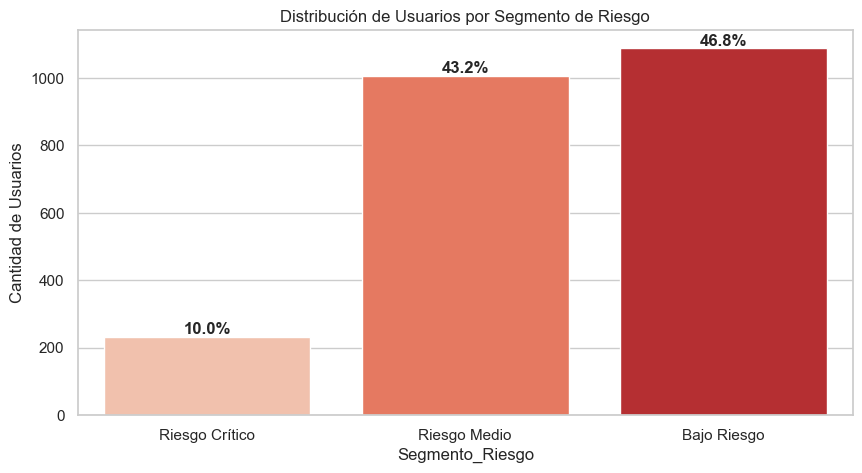

                 count      mean       min       max
Segmento_Riesgo                                     
Bajo Riesgo       1087  3.391151  0.150685  4.993836
Riesgo Crítico     232  8.796460  8.000000  9.958904
Riesgo Medio      1005  6.335550  5.008219  7.996575


In [2]:
# 1. Normalización de variables críticas para el Score
# Inactividad: a más días, mayor riesgo (Escala 0-5)
df['score_inactividad'] = (df['Dias_Inactivo'] / df['Dias_Inactivo'].max()) * 5

# Progreso: a menor progreso, mayor riesgo (usamos 100 - progreso) (Escala 0-5)
df['score_progreso'] = ((100 - df['Porcentaje_Completado']) / 100) * 5

# 2. Cálculo del Score Final (Base 10)
df['Risk_Score'] = df['score_inactividad'] + df['score_progreso']

# 3. Clasificación en Segmentos (Objetivo 2)
def segmentar_riesgo(score):
    if score >= 8: return 'Riesgo Crítico'
    if score >= 5: return 'Riesgo Medio'
    return 'Bajo Riesgo'

df['Segmento_Riesgo'] = df['Risk_Score'].apply(segmentar_riesgo)

# 4. Visualización de la distribución (Sintaxis corregida para Seaborn v0.14+)
plt.figure(figsize=(10, 5))
ax = sns.countplot(
    data=df, 
    x='Segmento_Riesgo', 
    hue='Segmento_Riesgo', 
    palette='Reds_r', 
    order=['Riesgo Crítico', 'Riesgo Medio', 'Bajo Riesgo'],
    legend=False
)

plt.title('Distribución de Usuarios por Segmento de Riesgo')
plt.ylabel('Cantidad de Usuarios')

# Añadimos etiquetas de porcentaje sobre las barras para reporte técnico
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontweight='bold')

# Exportación para Reporte Ejecutivo
plt.savefig('figures/fig_distribucion_riesgo.png', dpi=300, bbox_inches='tight')

plt.show()

# Resumen estadístico por segmento
resumen_segmentos = df.groupby('Segmento_Riesgo', observed=True)['Risk_Score'].agg(['count', 'mean', 'min', 'max'])
print(resumen_segmentos)

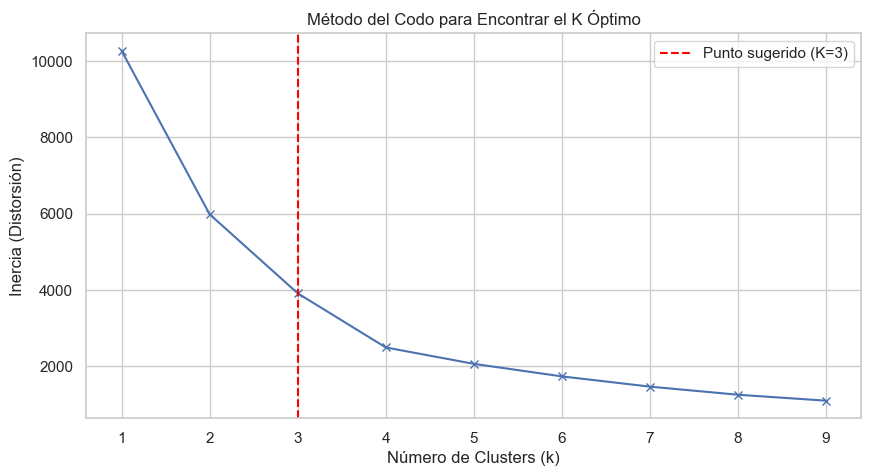

In [3]:
# 1. Seleccionamos las variables para el clustering (Escaladas previamente en el score)
X = df[['score_inactividad', 'score_progreso']]

# 2. Calculamos la inercia para diferentes valores de K
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

# 3. Visualización del Método del Codo
plt.figure(figsize=(10, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (Distorsión)')
plt.title('Método del Codo para Encontrar el K Óptimo')
plt.axvline(x=3, color='red', linestyle='--', label='Punto sugerido (K=3)') # Basado en nuestra segmentación previa
plt.legend()
plt.show()

In [4]:
df.to_csv('../data/processed/df_maestro_unificado_scored.csv', index=False)
print(" Dataset con Scoring e IA exportado correctamente.")

 Dataset con Scoring e IA exportado correctamente.


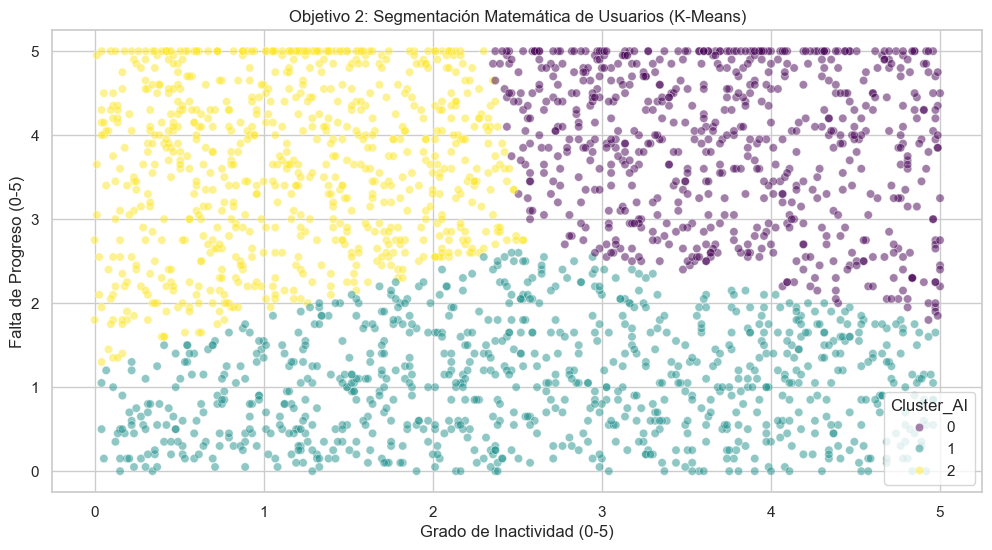

Comparativa: Nuestra Lógica vs Inteligencia Artificial
Cluster_AI         0    1    2
Segmento_Riesgo               
Bajo Riesgo        0  678  409
Riesgo Crítico   232    0    0
Riesgo Medio     454  201  350


In [5]:
# 1. Ejecutamos el modelo final con K=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster_AI'] = kmeans.fit_predict(df[['score_inactividad', 'score_progreso']])

# 2. Visualización de los Clusters (Sintaxis limpia de warnings)
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df, 
    x='score_inactividad', 
    y='score_progreso', 
    hue='Cluster_AI', 
    palette='viridis',
    alpha=0.5
)

plt.title('Objetivo 2: Segmentación Matemática de Usuarios (K-Means)')
plt.xlabel('Grado de Inactividad (0-5)')
plt.ylabel('Falta de Progreso (0-5)')

# Exportación para Reporte Ejecutivo
plt.savefig('figures/fig_clusters_ai.png', dpi=300, bbox_inches='tight')

plt.show()

# 3. Validación de consistencia: Manual vs IA
tabla_validacion = pd.crosstab(df['Segmento_Riesgo'], df['Cluster_AI'])
print("Comparativa: Nuestra Lógica vs Inteligencia Artificial")
print(tabla_validacion)

In [6]:
# SANEAMIENTO DE INTEGRIDAD (POST-SCORING)
# 1. Cargamos la versión que ya tiene Score e IA para sanearla
df_scored = pd.read_csv('../data/processed/df_maestro_unificado_scored.csv')

# 2. Forzamos conversión de fechas para validación temporal
df_scored['Fecha_Actividad'] = pd.to_datetime(df_scored['Fecha_Actividad'], errors='coerce')
df_scored['Fecha_Inicio'] = pd.to_datetime(df_scored['Fecha_Inicio'], errors='coerce')

# 3. Filtro de integridad: Eliminamos huérfanos y actividad pre-registro
# Esto evita que la retención supere el 100%
antes = len(df_scored)
df_clean = df_scored.dropna(subset=['Fecha_Inicio']).copy()
df_clean = df_clean[df_clean['Fecha_Actividad'] >= df_clean['Fecha_Inicio']].copy()

# 4. Recálculo del Día de Vida corregido
df_clean['Dia_Vida'] = (df_clean['Fecha_Actividad'] - df_clean['Fecha_Inicio']).dt.days

# 5. Sobrescritura final del archivo maestro
df_clean.to_csv('../data/processed/df_maestro_unificado_scored.csv', index=False)

print(" Saneamiento completado con éxito.")
print("-" * 30)
print(f" Registros originales: {antes}")
print(f" Registros saneados: {len(df_clean)}")
print(f" Delta eliminado: {antes - len(df_clean)}")

 Saneamiento completado con éxito.
------------------------------
 Registros originales: 2324
 Registros saneados: 1168
 Delta eliminado: 1156


In [7]:
import os

# Crear carpeta de figuras si no existe
if not os.path.exists('figures'):
    os.makedirs('figures')
    print("📁 Carpeta 'figures' creada para los reportes.")